<a href="https://colab.research.google.com/github/Solrak97/clasificador_de_sentimientos/blob/main/Notebooks/Analisis_preliminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis preeliminar de los datos

## Importación de los datos desde Kaggle

In [ ]:
%%capture
! pip install kaggle wavio pydub keras-metrics
! rm -rf *
! mkdir ~/.kaggle
! curl https://raw.githubusercontent.com/Solrak97/clasificador_de_sentimientos/main/kaggle.json > kaggle.json
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
! unzip ravdess-emotional-speech-audio.zip

In [ ]:
import soundfile
import numpy as np
import librosa
import glob
import os
from pydub import AudioSegment
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Transformación de los datos a las caracteristicas base del estudio Dias Issa et al.
Se extraerá un grupo de caracteristicas para analizar, hemos notado que hay diferencias en los tamaños de los audios por lo que hemos decidido revisar como funcionan correctamente los tamaños de datos y otras de estas caracteristicas.

In [ ]:
INT_2_EMOTION = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [ ]:
name, _len, emotions, mfccs, chromas, mels, contrasts, tonnetz = [], [], [], [], [], [], [], []

for file in glob.glob("Actor_*/*.wav"):
      file_name = os.path.basename(file)

      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      name_split = file_name.split("-")
      emotion = INT_2_EMOTION[name_split[2]]

      with soundfile.SoundFile(file) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X))
        mfccs.append(np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=84).T, axis=0))
        chromas.append(np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0))
        mels.append(np.mean(librosa.feature.melspectrogram(X, sr=sample_rate, n_mels=84).T,axis=0))
        contrasts.append(np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0))
        tonnetz.append(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0))
        
        _len.append(librosa.get_duration(y=X, sr=sample_rate))         

      name.append(file_name)
      emotions.append(emotion)

data = pd.DataFrame({'File name': name, 'Emotion': emotions, 'Duration': _len,
                        'MFCC': mfccs, 'Chroma': chromas, 'Mel': mels, 'Contrast': contrasts, 'Tonnetz': tonnetz})

In [ ]:
#data.to_pickle('data.pkl')
data = pd.read_pickle('data.pkl')

## Transformación de los datos utilizando PCA

In [ ]:
X = data.drop(columns=['Emotion', 'File name'])

# Forgive me god, but it has to be done
X = np.array([np.hstack([X['MFCC'][i], X['Chroma'][i], X['Mel'][i], 
                         X['Contrast'][i], X['Tonnetz'][i]]) for i in range(len(X.index))])

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X) 


pca = PCA(3)
reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.22510771, 0.09686766, 0.08505836])

### Separación no supervisada como intento de visualizar los datos agrupados.

In [ ]:
from sklearn.cluster import KMeans

label = KMeans(n_clusters=8, random_state=0).fit_predict(reduced)
labeled_kmeans = pd.DataFrame({'X': reduced[:,0], 'Y': reduced[:,1], 'label': label, 'Emotion': data['Emotion']})


filtered_label0 = reduced[label == 0]
filtered_label0 = reduced[label == 1]
filtered_label0 = reduced[label == 2]
filtered_label0 = reduced[label == 3]
filtered_label0 = reduced[label == 4]
filtered_label0 = reduced[label == 5]
filtered_label0 = reduced[label == 6]
filtered_label0 = reduced[label == 7]
 

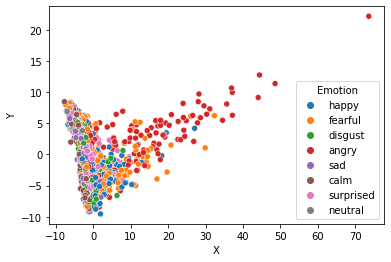

In [ ]:
sns.scatterplot(data=labeled_kmeans, x="X", y="Y", hue='Emotion')
plt.show()

## Prueba de separación con el base model

In [ ]:
from keras import Sequential
from keras.layers import Dropout, MaxPool1D, Flatten, Dense, ReLU, Input, BatchNormalization, Softmax
from keras.layers.convolutional import Conv1D
from keras.layers.advanced_activations import Softmax
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
def build_baseline():
  model = Sequential()

  # input layer
  model.add(Input(shape=(193, 1)))
  
  # Primer Convolutional layer
  model.add(Conv1D(strides=1, filters=255, kernel_size=5))
  model.add(BatchNormalization())
  model.add(ReLU())

  # Segund Convolutional layer
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())
  model.add(Dropout(rate=0.1))
  model.add(BatchNormalization())

  # Capa de Maxpooling
  model.add(MaxPool1D(pool_size=8))

  # 3 capas convolucionales intermedias
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())

  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(ReLU())

  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(rate=0.2))

  # Capa convolucional final
  model.add(Conv1D(strides=1, filters=128, kernel_size=5))
  model.add(Flatten())
  model.add(Dropout(rate=0.2))

  # Capa densa, tiene la misma cantidad de neuronas que de clases a predecir
  model.add(Dense(units=8))
  model.add(BatchNormalization())
  model.add(Softmax())  
  return model

### Preparación de los datos

In [ ]:
# Forgive me god, but it has to be done twice
X = np.array([np.hstack([data['MFCC'][i], data['Chroma'][i], data['Mel'][i], 
                         data['Contrast'][i], data['Tonnetz'][i]]) for i in range(len(data.index))])

print(X.shape)

scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
Y = np.array(data['Emotion'])

# Codificación de one hot encoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, Y)

(1440, 193)


### Entrenamiento y predicciones

In [ ]:
model = build_baseline()
model.compile(optimizer = RMSprop(learning_rate=1e-5) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 189, 255)          1530      
                                                                 
 batch_normalization_4 (Batc  (None, 189, 255)         1020      
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 189, 255)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 185, 128)          163328    
                                                                 
 re_lu_6 (ReLU)              (None, 185, 128)          0         
                                                                 
 dropout_3 (Dropout)         (None, 185, 128)          0         
                                                      

In [ ]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
34/34 [==============================] - 2s 12ms/step - loss: 2.2527 - accuracy: 0.1481
Epoch 2/100
34/34 [==============================] - 0s 10ms/step - loss: 2.2032 - accuracy: 0.1750
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 2.1300 - accuracy: 0.1935
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 2.0775 - accuracy: 0.2074
Epoch 5/100
34/34 [==============================] - 0s 10ms/step - loss: 1.9972 - accuracy: 0.2472
Epoch 6/100
34/34 [==============================] - 0s 10ms/step - loss: 1.9896 - accuracy: 0.2250
Epoch 7/100
34/34 [==============================] - 0s 10ms/step - loss: 1.9344 - accuracy: 0.2519
Epoch 8/100
34/34 [==============================] - 0s 10ms/step - loss: 1.8773 - accuracy: 0.2667
Epoch 9/100
34/34 [==============================] - 0s 10ms/step - loss: 1.8793 - accuracy: 0.2769
Epoch 10/100
34/34 [==============================] - 0s 10ms/step - loss: 1.8585 - accuracy: 0.2806

In [ ]:
#pred = model.predict(X_test)

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 5ms/step - loss: 1.6524 - accuracy: 0.3861
Test loss: 1.6523858308792114
Test accuracy: 0.3861111104488373
